In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
!ls '/content/drive/MyDrive/Colab_Notebooks/DL_final/'


BuzzFeed	       feature_matrix_pf.csv		  UserFeature.mat
BuzzFeedNewsUser.txt   news_news_bf_adjacency_matrix.csv  User.txt
BuzzFeedUserUser.txt   news_news_pf_adjacency_matrix.csv
feature_matrix_bf.csv  News.txt


In [4]:
!pwd

/content


In [5]:
import numpy as np
import tensorflow as tf
import argparse
import scipy.sparse as sp
import pandas as pd 
import random
import json
import os

from feature_matrix import FeatureMatrix

import pandas as pd 
import tensorflow_hub as hub
from bert import run_classifier
from bert import tokenization


In [6]:
FM = FeatureMatrix(base_path = "/content/drive/MyDrive/Colab_Notebooks/DL_final//")
label_zip = None

In [7]:
 def getAdj( dataset="BuzzFeed"):
        if dataset == "BuzzFeed":
            adj_np = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/DL_final/news_news_bf_adjacency_matrix.csv", header=None).values
        else:
            adj_np = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/DL_final/news_news_pf_adjacency_matrix.csv", header=None).values

        return sp.csr_matrix(adj_np, dtype=int)


In [8]:
    def getFeatures( dataset="BuzzFeed"):
        feature_df =  FM.get_feature_matrix(dataset)
        label = feature_df['label'].tolist()
        label_comp = [0 if each else 1 for each in label]
        global label_zip
        label_zip = list(zip(label_comp, label))
        feature_df.drop(['label'], axis=1)
        feature_np = feature_df.values

        return sp.csr_matrix(feature_np, dtype=float).tolil()

In [9]:
    def getYs(  dataset="BuzzFeed"):
        if dataset == "BuzzFeed":
            random.seed(1)
        else:
            random.seed(1)
        yTrain =  label_zip[:]
        yVal =  label_zip[:]
        yTest =  label_zip[:]
        train_mask = [False] * len(yTrain)
        val_mask = [False] * len(yTrain)
        test_mask = [False] * len(yTrain)
        n = len(yTrain)

        set_of_records_range = set(range(n))

        train_range = set(random.sample(set_of_records_range, k=int(n * 0.6)))
        set_of_records_range = set_of_records_range - train_range

        val_range = set(random.sample(set_of_records_range, k=int(n * 0.2)))
        set_of_records_range = set_of_records_range - train_range

        test_range = set(random.sample(set_of_records_range, k=int(n * 0.2)))

        for i in train_range:
            yVal[i] = (0,0)
            yTest[i] = (0,0)
            train_mask[i] = True
        for i in val_range:
            yTrain[i] = (0,0)
            yTest[i] = (0,0)
            val_mask[i] = True
        for i in test_range:
            yVal[i] = (0,0)
            yTrain[i] = (0,0)
            test_mask[i] = True

        return yTrain, yVal, yTest, train_mask, val_mask, test_mask


In [10]:
    def getComps(  dataset="BuzzFeed"):
        print(dataset)
        adj =  getAdj(dataset)
        features =  getFeatures(dataset)

        yTrain, yVal, yTest, train_mask, val_mask, test_mask =  getYs(dataset)

        return adj, features, yTrain, yVal, yTest, train_mask, val_mask, test_mask


In [11]:
def sparse_to_tuple(sparse_mx):
    """Convert sparse matrix to tuple representation."""
    def to_tuple(mx):
        if not sp.isspmatrix_coo(mx):
            mx = mx.tocoo()
        coords = np.vstack((mx.row, mx.col)).transpose()
        values = mx.data
        shape = mx.shape
        return coords, values, shape

    if isinstance(sparse_mx, list):
        for i in range(len(sparse_mx)):
            sparse_mx[i] = to_tuple(sparse_mx[i])
    else:
        sparse_mx = to_tuple(sparse_mx)

    return sparse_mx


In [12]:
def preprocess_features(features):
    """Row-normalize feature matrix and convert to tuple representation"""
    rowsum = np.array(features.sum(1))
    r_inv = np.power(rowsum, -1, dtype=float).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    features = r_mat_inv.dot(features)
    return features.todense(), sparse_to_tuple(features)

In [13]:
def adj_to_bias(adj, sizes, nhood=1):
    nb_graphs = adj.shape[0]
    mt = np.empty(adj.shape)
    for g in range(nb_graphs):
        mt[g] = np.eye(adj.shape[1])
        for _ in range(nhood):
            mt[g] = np.matmul(mt[g], (adj[g] + np.eye(adj.shape[1])))
        for i in range(sizes[g]):
            for j in range(sizes[g]):
                if mt[g][i][j] > 0.0:
                    mt[g][i][j] = 1.0
    return -1e9 * (1.0 - mt)


In [14]:

adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask = getComps(dataset='BuzzFeed')
features, spars = preprocess_features(features)

BuzzFeed
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Writing example 0 of 182


INFO:tensorflow:Writing example 0 of 182


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 61 . 3 ##k shares facebook twitter update : buzz ##fe ##ed has deemed that our description of the crime and the victims is false . we have utterly de ##bu ##nk ##ed buzz ##fe ##ed ’ s claims . you can view our follow ##up article here . ~ ~ ~ you can ’ t make this stuff up . people used to tell crazy stories , but have no way to prove if the story was true or not . then along came video . this is by far one of the cr ##azi ##est things i ’ ve ever seen . these guys are out in the middle of the street and it looks like there was supposed to be a fight of [SEP]


INFO:tensorflow:tokens: [CLS] 61 . 3 ##k shares facebook twitter update : buzz ##fe ##ed has deemed that our description of the crime and the victims is false . we have utterly de ##bu ##nk ##ed buzz ##fe ##ed ’ s claims . you can view our follow ##up article here . ~ ~ ~ you can ’ t make this stuff up . people used to tell crazy stories , but have no way to prove if the story was true or not . then along came video . this is by far one of the cr ##azi ##est things i ’ ve ever seen . these guys are out in the middle of the street and it looks like there was supposed to be a fight of [SEP]


INFO:tensorflow:input_ids: 101 6079 1012 1017 2243 6661 9130 10474 10651 1024 12610 7959 2098 2038 8357 2008 2256 6412 1997 1996 4126 1998 1996 5694 2003 6270 1012 2057 2031 12580 2139 8569 8950 2098 12610 7959 2098 1521 1055 4447 1012 2017 2064 3193 2256 3582 6279 3720 2182 1012 1066 1066 1066 2017 2064 1521 1056 2191 2023 4933 2039 1012 2111 2109 2000 2425 4689 3441 1010 2021 2031 2053 2126 2000 6011 2065 1996 2466 2001 2995 2030 2025 1012 2059 2247 2234 2678 1012 2023 2003 2011 2521 2028 1997 1996 13675 16103 4355 2477 1045 1521 2310 2412 2464 1012 2122 4364 2024 2041 1999 1996 2690 1997 1996 2395 1998 2009 3504 2066 2045 2001 4011 2000 2022 1037 2954 1997 102


INFO:tensorflow:input_ids: 101 6079 1012 1017 2243 6661 9130 10474 10651 1024 12610 7959 2098 2038 8357 2008 2256 6412 1997 1996 4126 1998 1996 5694 2003 6270 1012 2057 2031 12580 2139 8569 8950 2098 12610 7959 2098 1521 1055 4447 1012 2017 2064 3193 2256 3582 6279 3720 2182 1012 1066 1066 1066 2017 2064 1521 1056 2191 2023 4933 2039 1012 2111 2109 2000 2425 4689 3441 1010 2021 2031 2053 2126 2000 6011 2065 1996 2466 2001 2995 2030 2025 1012 2059 2247 2234 2678 1012 2023 2003 2011 2521 2028 1997 1996 13675 16103 4355 2477 1045 1521 2310 2412 2464 1012 2122 4364 2024 2041 1999 1996 2690 1997 1996 2395 1998 2009 3504 2066 2045 2001 4011 2000 2022 1037 2954 1997 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] the man arrested monday in connection with the new york city bombing sued his local police force over anti - muslim discrimination claims . ahmad khan ra ##ham ##i filed the lawsuit against cops in elizabeth , n . j . , where he was residing before he planted bombs in the chelsea neighborhood of manhattan , at a train station in elizabeth , and on the route of a 5 ##k marine charity run on the jersey shore . he claimed police were per ##se ##cuting him for being a muslim and subject ##ing him and his family to “ selective enforcement ” based on islam , reports the daily mail . ra ##ham ##i worked at a chicken restaurant called first american , owned [SEP]


INFO:tensorflow:tokens: [CLS] the man arrested monday in connection with the new york city bombing sued his local police force over anti - muslim discrimination claims . ahmad khan ra ##ham ##i filed the lawsuit against cops in elizabeth , n . j . , where he was residing before he planted bombs in the chelsea neighborhood of manhattan , at a train station in elizabeth , and on the route of a 5 ##k marine charity run on the jersey shore . he claimed police were per ##se ##cuting him for being a muslim and subject ##ing him and his family to “ selective enforcement ” based on islam , reports the daily mail . ra ##ham ##i worked at a chicken restaurant called first american , owned [SEP]


INFO:tensorflow:input_ids: 101 1996 2158 4727 6928 1999 4434 2007 1996 2047 2259 2103 8647 12923 2010 2334 2610 2486 2058 3424 1011 5152 9147 4447 1012 10781 4967 10958 3511 2072 6406 1996 9870 2114 10558 1999 3870 1010 1050 1012 1046 1012 1010 2073 2002 2001 7154 2077 2002 8461 9767 1999 1996 9295 5101 1997 7128 1010 2012 1037 3345 2276 1999 3870 1010 1998 2006 1996 2799 1997 1037 1019 2243 3884 5952 2448 2006 1996 3933 5370 1012 2002 3555 2610 2020 2566 3366 29163 2032 2005 2108 1037 5152 1998 3395 2075 2032 1998 2010 2155 2000 1523 13228 7285 1524 2241 2006 7025 1010 4311 1996 3679 5653 1012 10958 3511 2072 2499 2012 1037 7975 4825 2170 2034 2137 1010 3079 102


INFO:tensorflow:input_ids: 101 1996 2158 4727 6928 1999 4434 2007 1996 2047 2259 2103 8647 12923 2010 2334 2610 2486 2058 3424 1011 5152 9147 4447 1012 10781 4967 10958 3511 2072 6406 1996 9870 2114 10558 1999 3870 1010 1050 1012 1046 1012 1010 2073 2002 2001 7154 2077 2002 8461 9767 1999 1996 9295 5101 1997 7128 1010 2012 1037 3345 2276 1999 3870 1010 1998 2006 1996 2799 1997 1037 1019 2243 3884 5952 2448 2006 1996 3933 5370 1012 2002 3555 2610 2020 2566 3366 29163 2032 2005 2108 1037 5152 1998 3395 2075 2032 1998 2010 2155 2000 1523 13228 7285 1524 2241 2006 7025 1010 4311 1996 3679 5653 1012 10958 3511 2072 2499 2012 1037 7975 4825 2170 2034 2137 1010 3079 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] exposed : so ##ros funding fake veterans ’ pac to take trump down a couple months ago , discover the networks revealed a list of 187 groups who were funded by so ##ros . they have naturally been attacking the presidential candidate who is generally against their values like open borders , amnesty , giving illegal ##s voting rights , muslim migration and social justice . so , why then is so ##ros caught again ? now a new organization is going after trump and sure enough , they ’ re funded by so ##ros too ! it ’ s called ‘ common defense pac ’ and their mantra is : “ as veterans , we swore to protect the rights of every american . we [SEP]


INFO:tensorflow:tokens: [CLS] exposed : so ##ros funding fake veterans ’ pac to take trump down a couple months ago , discover the networks revealed a list of 187 groups who were funded by so ##ros . they have naturally been attacking the presidential candidate who is generally against their values like open borders , amnesty , giving illegal ##s voting rights , muslim migration and social justice . so , why then is so ##ros caught again ? now a new organization is going after trump and sure enough , they ’ re funded by so ##ros too ! it ’ s called ‘ common defense pac ’ and their mantra is : “ as veterans , we swore to protect the rights of every american . we [SEP]


INFO:tensorflow:input_ids: 101 6086 1024 2061 7352 4804 8275 8244 1521 14397 2000 2202 8398 2091 1037 3232 2706 3283 1010 7523 1996 6125 3936 1037 2862 1997 19446 2967 2040 2020 6787 2011 2061 7352 1012 2027 2031 8100 2042 7866 1996 4883 4018 2040 2003 3227 2114 2037 5300 2066 2330 6645 1010 16154 1010 3228 6206 2015 6830 2916 1010 5152 9230 1998 2591 3425 1012 2061 1010 2339 2059 2003 2061 7352 3236 2153 1029 2085 1037 2047 3029 2003 2183 2044 8398 1998 2469 2438 1010 2027 1521 2128 6787 2011 2061 7352 2205 999 2009 1521 1055 2170 1520 2691 3639 14397 1521 1998 2037 25951 2003 1024 1523 2004 8244 1010 2057 12860 2000 4047 1996 2916 1997 2296 2137 1012 2057 102


INFO:tensorflow:input_ids: 101 6086 1024 2061 7352 4804 8275 8244 1521 14397 2000 2202 8398 2091 1037 3232 2706 3283 1010 7523 1996 6125 3936 1037 2862 1997 19446 2967 2040 2020 6787 2011 2061 7352 1012 2027 2031 8100 2042 7866 1996 4883 4018 2040 2003 3227 2114 2037 5300 2066 2330 6645 1010 16154 1010 3228 6206 2015 6830 2916 1010 5152 9230 1998 2591 3425 1012 2061 1010 2339 2059 2003 2061 7352 3236 2153 1029 2085 1037 2047 3029 2003 2183 2044 8398 1998 2469 2438 1010 2027 1521 2128 6787 2011 2061 7352 2205 999 2009 1521 1055 2170 1520 2691 3639 14397 1521 1998 2037 25951 2003 1024 1523 2004 8244 1010 2057 12860 2000 4047 1996 2916 1997 2296 2137 1012 2057 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] this is a true story . general stanley mcc ##hr ##yst ##al was the commander of us forces in afghanistan and he had frequent disagreements on the conduct of the war with his commander - in - chief . at one point mcc ##hr ##yst ##al was called into the oval office and he knew his army career was about to be over . when former u . s . military commander in afghanistan , stanley mcc ##hr ##yst ##al , was called into the oval office by barack obama , he knew things weren ’ t going to go well when the president accused him of not supporting him in his political role as president . “ it ’ s not my job to support [SEP]


INFO:tensorflow:tokens: [CLS] this is a true story . general stanley mcc ##hr ##yst ##al was the commander of us forces in afghanistan and he had frequent disagreements on the conduct of the war with his commander - in - chief . at one point mcc ##hr ##yst ##al was called into the oval office and he knew his army career was about to be over . when former u . s . military commander in afghanistan , stanley mcc ##hr ##yst ##al , was called into the oval office by barack obama , he knew things weren ’ t going to go well when the president accused him of not supporting him in his political role as president . “ it ’ s not my job to support [SEP]


INFO:tensorflow:input_ids: 101 2023 2003 1037 2995 2466 1012 2236 6156 23680 8093 27268 2389 2001 1996 3474 1997 2149 2749 1999 7041 1998 2002 2018 6976 23145 2006 1996 6204 1997 1996 2162 2007 2010 3474 1011 1999 1011 2708 1012 2012 2028 2391 23680 8093 27268 2389 2001 2170 2046 1996 9242 2436 1998 2002 2354 2010 2390 2476 2001 2055 2000 2022 2058 1012 2043 2280 1057 1012 1055 1012 2510 3474 1999 7041 1010 6156 23680 8093 27268 2389 1010 2001 2170 2046 1996 9242 2436 2011 13857 8112 1010 2002 2354 2477 4694 1521 1056 2183 2000 2175 2092 2043 1996 2343 5496 2032 1997 2025 4637 2032 1999 2010 2576 2535 2004 2343 1012 1523 2009 1521 1055 2025 2026 3105 2000 2490 102


INFO:tensorflow:input_ids: 101 2023 2003 1037 2995 2466 1012 2236 6156 23680 8093 27268 2389 2001 1996 3474 1997 2149 2749 1999 7041 1998 2002 2018 6976 23145 2006 1996 6204 1997 1996 2162 2007 2010 3474 1011 1999 1011 2708 1012 2012 2028 2391 23680 8093 27268 2389 2001 2170 2046 1996 9242 2436 1998 2002 2354 2010 2390 2476 2001 2055 2000 2022 2058 1012 2043 2280 1057 1012 1055 1012 2510 3474 1999 7041 1010 6156 23680 8093 27268 2389 1010 2001 2170 2046 1996 9242 2436 2011 13857 8112 1010 2002 2354 2477 4694 1521 1056 2183 2000 2175 2092 2043 1996 2343 5496 2032 1997 2025 4637 2032 1999 2010 2576 2535 2004 2343 1012 1523 2009 1521 1055 2025 2026 3105 2000 2490 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] " he didn ' t ask her about a lot of things she should have been asked about , " donald trump said about lester holt . | get ##ty post - debate , trump team hits moderator holt for ' some hostile questions ' donald trump and his campaign complained tuesday morning that debate moderator lester holt targeted him for unfair questioning while neglect ##ing to ask hillary clinton about any of her various scandals . “ they were leaving all of her little good ##ies out . they didn ' t ask her about , you know , much , ” trump said on fox news ’ s “ fox and friends . ” “ but i was asked about my tax returns , [SEP]


INFO:tensorflow:tokens: [CLS] " he didn ' t ask her about a lot of things she should have been asked about , " donald trump said about lester holt . | get ##ty post - debate , trump team hits moderator holt for ' some hostile questions ' donald trump and his campaign complained tuesday morning that debate moderator lester holt targeted him for unfair questioning while neglect ##ing to ask hillary clinton about any of her various scandals . “ they were leaving all of her little good ##ies out . they didn ' t ask her about , you know , much , ” trump said on fox news ’ s “ fox and friends . ” “ but i was asked about my tax returns , [SEP]


INFO:tensorflow:input_ids: 101 1000 2002 2134 1005 1056 3198 2014 2055 1037 2843 1997 2477 2016 2323 2031 2042 2356 2055 1010 1000 6221 8398 2056 2055 14131 12621 1012 1064 2131 3723 2695 1011 5981 1010 8398 2136 4978 29420 12621 2005 1005 2070 10420 3980 1005 6221 8398 1998 2010 3049 10865 9857 2851 2008 5981 29420 14131 12621 9416 2032 2005 15571 11242 2096 19046 2075 2000 3198 18520 7207 2055 2151 1997 2014 2536 29609 1012 1523 2027 2020 2975 2035 1997 2014 2210 2204 3111 2041 1012 2027 2134 1005 1056 3198 2014 2055 1010 2017 2113 1010 2172 1010 1524 8398 2056 2006 4419 2739 1521 1055 1523 4419 1998 2814 1012 1524 1523 2021 1045 2001 2356 2055 2026 4171 5651 1010 102


INFO:tensorflow:input_ids: 101 1000 2002 2134 1005 1056 3198 2014 2055 1037 2843 1997 2477 2016 2323 2031 2042 2356 2055 1010 1000 6221 8398 2056 2055 14131 12621 1012 1064 2131 3723 2695 1011 5981 1010 8398 2136 4978 29420 12621 2005 1005 2070 10420 3980 1005 6221 8398 1998 2010 3049 10865 9857 2851 2008 5981 29420 14131 12621 9416 2032 2005 15571 11242 2096 19046 2075 2000 3198 18520 7207 2055 2151 1997 2014 2536 29609 1012 1523 2027 2020 2975 2035 1997 2014 2210 2204 3111 2041 1012 2027 2134 1005 1056 3198 2014 2055 1010 2017 2113 1010 2172 1010 1524 8398 2056 2006 4419 2739 1521 1055 1523 4419 1998 2814 1012 1524 1523 2021 1045 2001 2356 2055 2026 4171 5651 1010 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


In [38]:
features=sp.csr_matrix(features)

y_train  = np.asarray(y_train)
y_val = np.asarray(y_val)
y_test = np.asarray(y_test)
train_mask  = np.asarray(train_mask)
val_mask  = np.asarray(val_mask)
test_mask  = np.asarray(test_mask)

In [42]:
from scipy import sparse

sparse.save_npz("features.npz", features)
sparse.save_npz("adj.npz", adj)
# your_matrix_back = sparse.load_npz("yourmatrix.npz")
with open('array.npy', 'wb') as f:
    np.save(f, y_train )
    np.save(f,  y_val)
    np.save(f, y_test )
    np.save(f, train_mask )
    np.save(f,  val_mask)
    np.save(f, test_mask )

In [43]:
features = scipy.sparse.load_npz("features.npz")
adj = scipy.sparse.load_npz("adj.npz")

with open('array.npy', 'rb') as f:
    y_train = np.load(f)
    y_val = np.load(f)
    y_test = np.load(f)
    train_mask = np.load(f)
    val_mask = np.load(f)
    test_mask = np.load(f)

In [15]:
from __future__ import division
from __future__ import print_function

import time
import tensorflow as tf 
from  utils import *
from models import GCN, MLP

# Set random seed
seed = 123
np.random.seed(seed)
tf.set_random_seed(seed)

# Settings
flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_string('f', '', 'kernel')
# flags.DEFINE_string('dataset', 'cora', 'Dataset string.')  # 'cora', 'citeseer', 'pubmed'
# flags.DEFINE_string('model', 'gcn', 'Model string.')  # 'gcn', 'gcn_cheby', 'dense'
# flags.DEFINE_float('learning_rate', 0.01, 'Initial learning rate.')
flags.DEFINE_integer('epochs', 200, 'Number of epochs to train.')
flags.DEFINE_integer('hidden1', 16, 'Number of units in hidden layer 1.')
flags.DEFINE_float('dropout', 0.5, 'Dropout rate (1 - keep probability).')
flags.DEFINE_float('weight_decay', 5e-4, 'Weight for L2 loss on embedding matrix.')
flags.DEFINE_integer('early_stopping', 10, 'Tolerance for early stopping (# of epochs).')
flags.DEFINE_integer('max_degree', 3, 'Maximum Chebyshev polynomial degree.')

# Load data
adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask = getComps(dataset='BuzzFeed')
features=sp.csr_matrix(features)
# Some preprocessing
features = preprocess_features(features)
# if FLAGS.model == 'gcn':
support = [preprocess_adj(adj)]
num_supports = 1
model_func = GCN
# elif FLAGS.model == 'gcn_cheby':
#     support = chebyshev_polynomials(adj, FLAGS.max_degree)
#     num_supports = 1 + FLAGS.max_degree
#     model_func = GCN
# elif FLAGS.model == 'dense':
#     support = [preprocess_adj(adj)]  # Not used
#     num_supports = 1
#     model_func = MLP
# else:
#     raise ValueError('Invalid argument for model: ' + str(FLAGS.model))

y_train  = np.asarray(y_train)
y_val = np.asarray(y_val)
y_test = np.asarray(y_test)
train_mask  = np.asarray(train_mask)
val_mask  = np.asarray(val_mask)
test_mask  = np.asarray(test_mask)

# Define placeholders
placeholders = {
    'support': [tf.sparse_placeholder(tf.float32) for _ in range(num_supports)],
    'features': tf.sparse_placeholder(tf.float32, shape=tf.constant(features[2], dtype=tf.int64)),
    'labels': tf.placeholder(tf.float32, shape=(None, y_train.shape[1])),
    'labels_mask': tf.placeholder(tf.int32),
    'dropout': tf.placeholder_with_default(0., shape=()),
    'num_features_nonzero': tf.placeholder(tf.int32)  # helper variable for sparse dropout
}


BuzzFeed
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Writing example 0 of 182


INFO:tensorflow:Writing example 0 of 182


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] friday morning around 4 : 00 , three men – some of whom were armed – barge ##d in through one of the doors of an atlanta resident ’ s house . the resident ’ s co - worker was over for work - related reasons , and when she heard the commotion , she sprung into action , wielding a handgun . the whole episode was caught on surveillance camera that was set up inside the house . the resident ’ s co - worker un ##loaded all the rounds from her gun into the intruder ##s ’ direction , sending all three of them out the door . one of the intruder ##s even jumped through a glass door . two intruder ##s are [SEP]


INFO:tensorflow:tokens: [CLS] friday morning around 4 : 00 , three men – some of whom were armed – barge ##d in through one of the doors of an atlanta resident ’ s house . the resident ’ s co - worker was over for work - related reasons , and when she heard the commotion , she sprung into action , wielding a handgun . the whole episode was caught on surveillance camera that was set up inside the house . the resident ’ s co - worker un ##loaded all the rounds from her gun into the intruder ##s ’ direction , sending all three of them out the door . one of the intruder ##s even jumped through a glass door . two intruder ##s are [SEP]


INFO:tensorflow:input_ids: 101 5958 2851 2105 1018 1024 4002 1010 2093 2273 1516 2070 1997 3183 2020 4273 1516 19398 2094 1999 2083 2028 1997 1996 4303 1997 2019 5865 6319 1521 1055 2160 1012 1996 6319 1521 1055 2522 1011 7309 2001 2058 2005 2147 1011 3141 4436 1010 1998 2043 2016 2657 1996 23960 1010 2016 22057 2046 2895 1010 26974 1037 28497 1012 1996 2878 2792 2001 3236 2006 9867 4950 2008 2001 2275 2039 2503 1996 2160 1012 1996 6319 1521 1055 2522 1011 7309 4895 17468 2035 1996 6241 2013 2014 3282 2046 1996 22841 2015 1521 3257 1010 6016 2035 2093 1997 2068 2041 1996 2341 1012 2028 1997 1996 22841 2015 2130 5598 2083 1037 3221 2341 1012 2048 22841 2015 2024 102


INFO:tensorflow:input_ids: 101 5958 2851 2105 1018 1024 4002 1010 2093 2273 1516 2070 1997 3183 2020 4273 1516 19398 2094 1999 2083 2028 1997 1996 4303 1997 2019 5865 6319 1521 1055 2160 1012 1996 6319 1521 1055 2522 1011 7309 2001 2058 2005 2147 1011 3141 4436 1010 1998 2043 2016 2657 1996 23960 1010 2016 22057 2046 2895 1010 26974 1037 28497 1012 1996 2878 2792 2001 3236 2006 9867 4950 2008 2001 2275 2039 2503 1996 2160 1012 1996 6319 1521 1055 2522 1011 7309 4895 17468 2035 1996 6241 2013 2014 3282 2046 1996 22841 2015 1521 3257 1010 6016 2035 2093 1997 2068 2041 1996 2341 1012 2028 1997 1996 22841 2015 2130 5598 2083 1037 3221 2341 1012 2048 22841 2015 2024 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] story highlights a protest ##er pie ##d sacramento ' s mayor in the face at a charity event wednesday the two sc ##uf ##fle ##d afterward , and the protest ##er was taken to a hospital for stitches ( cnn ) kevin johnson - - the nba star - turned - sacramento mayor - - was pie ##d in the face by a man at a charity dinner wednesday night at the high school he once attended . but the pie - throw ##er appeared to get the worst of it . sean thompson , 32 , approached the mayor , pulled a pie out of the bag and shoving it in his face - - setting off a short sc ##uf ##fle , in which [SEP]


INFO:tensorflow:tokens: [CLS] story highlights a protest ##er pie ##d sacramento ' s mayor in the face at a charity event wednesday the two sc ##uf ##fle ##d afterward , and the protest ##er was taken to a hospital for stitches ( cnn ) kevin johnson - - the nba star - turned - sacramento mayor - - was pie ##d in the face by a man at a charity dinner wednesday night at the high school he once attended . but the pie - throw ##er appeared to get the worst of it . sean thompson , 32 , approached the mayor , pulled a pie out of the bag and shoving it in his face - - setting off a short sc ##uf ##fle , in which [SEP]


INFO:tensorflow:input_ids: 101 2466 11637 1037 6186 2121 11345 2094 11932 1005 1055 3664 1999 1996 2227 2012 1037 5952 2724 9317 1996 2048 8040 16093 21031 2094 9707 1010 1998 1996 6186 2121 2001 2579 2000 1037 2902 2005 25343 1006 13229 1007 4901 3779 1011 1011 1996 6452 2732 1011 2357 1011 11932 3664 1011 1011 2001 11345 2094 1999 1996 2227 2011 1037 2158 2012 1037 5952 4596 9317 2305 2012 1996 2152 2082 2002 2320 3230 1012 2021 1996 11345 1011 5466 2121 2596 2000 2131 1996 5409 1997 2009 1012 5977 5953 1010 3590 1010 5411 1996 3664 1010 2766 1037 11345 2041 1997 1996 4524 1998 15866 2009 1999 2010 2227 1011 1011 4292 2125 1037 2460 8040 16093 21031 1010 1999 2029 102


INFO:tensorflow:input_ids: 101 2466 11637 1037 6186 2121 11345 2094 11932 1005 1055 3664 1999 1996 2227 2012 1037 5952 2724 9317 1996 2048 8040 16093 21031 2094 9707 1010 1998 1996 6186 2121 2001 2579 2000 1037 2902 2005 25343 1006 13229 1007 4901 3779 1011 1011 1996 6452 2732 1011 2357 1011 11932 3664 1011 1011 2001 11345 2094 1999 1996 2227 2011 1037 2158 2012 1037 5952 4596 9317 2305 2012 1996 2152 2082 2002 2320 3230 1012 2021 1996 11345 1011 5466 2121 2596 2000 2131 1996 5409 1997 2009 1012 5977 5953 1010 3590 1010 5411 1996 3664 1010 2766 1037 11345 2041 1997 1996 4524 1998 15866 2009 1999 2010 2227 1011 1011 4292 2125 1037 2460 8040 16093 21031 1010 1999 2029 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 0 shares facebook twitter bernard sans ##ari ##c ##q , former president of the haitian senate , issued a b ##list ##ering statement condemning the clinton foundation , which has been posted at donald trump ’ s campaign website . sans ##ari ##c ##q ’ s statement says : sadly , when an earthquake rocked the nation of haiti in 2010 , corruption moved in faster than the help so desperately needed . today , the people of haiti are still suffering despite the billions of dollars that have flowed into the clinton foundation . the clinton ##s exploited this terrible disaster to steal billions of dollars from the sick and starving people of haiti . the world trusted the clinton ##s to help the haitian [SEP]


INFO:tensorflow:tokens: [CLS] 0 shares facebook twitter bernard sans ##ari ##c ##q , former president of the haitian senate , issued a b ##list ##ering statement condemning the clinton foundation , which has been posted at donald trump ’ s campaign website . sans ##ari ##c ##q ’ s statement says : sadly , when an earthquake rocked the nation of haiti in 2010 , corruption moved in faster than the help so desperately needed . today , the people of haiti are still suffering despite the billions of dollars that have flowed into the clinton foundation . the clinton ##s exploited this terrible disaster to steal billions of dollars from the sick and starving people of haiti . the world trusted the clinton ##s to help the haitian [SEP]


INFO:tensorflow:input_ids: 101 1014 6661 9130 10474 6795 20344 8486 2278 4160 1010 2280 2343 1997 1996 21404 4001 1010 3843 1037 1038 9863 7999 4861 28525 1996 7207 3192 1010 2029 2038 2042 6866 2012 6221 8398 1521 1055 3049 4037 1012 20344 8486 2278 4160 1521 1055 4861 2758 1024 13718 1010 2043 2019 8372 14215 1996 3842 1997 12867 1999 2230 1010 7897 2333 1999 5514 2084 1996 2393 2061 9652 2734 1012 2651 1010 1996 2111 1997 12867 2024 2145 6114 2750 1996 25501 1997 6363 2008 2031 13230 2046 1996 7207 3192 1012 1996 7207 2015 18516 2023 6659 7071 2000 8954 25501 1997 6363 2013 1996 5305 1998 18025 2111 1997 12867 1012 1996 2088 9480 1996 7207 2015 2000 2393 1996 21404 102


INFO:tensorflow:input_ids: 101 1014 6661 9130 10474 6795 20344 8486 2278 4160 1010 2280 2343 1997 1996 21404 4001 1010 3843 1037 1038 9863 7999 4861 28525 1996 7207 3192 1010 2029 2038 2042 6866 2012 6221 8398 1521 1055 3049 4037 1012 20344 8486 2278 4160 1521 1055 4861 2758 1024 13718 1010 2043 2019 8372 14215 1996 3842 1997 12867 1999 2230 1010 7897 2333 1999 5514 2084 1996 2393 2061 9652 2734 1012 2651 1010 1996 2111 1997 12867 2024 2145 6114 2750 1996 25501 1997 6363 2008 2031 13230 2046 1996 7207 3192 1012 1996 7207 2015 18516 2023 6659 7071 2000 8954 25501 1997 6363 2013 1996 5305 1998 18025 2111 1997 12867 1012 1996 2088 9480 1996 7207 2015 2000 2393 1996 21404 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] the democrats are using an intimidation tactic which they are prone to use inc ##ess ##antly . if you question the vera ##city of a black president ’ s birth certificate you are racist . that is the outright claim of lynn sweet washington bureau chief for the chicago sun - times made on fox news . consider the slant ##ed claim that if a president is black and his birth certificate is called into question the conclusion is you must be a racist . what is wrong with this obvious non - se ##qui ##tur ? first of all , there is evidence the birth certificate presented was altered . this is discount ##ed by the claims that whoever presented this must be racist . [SEP]


INFO:tensorflow:tokens: [CLS] the democrats are using an intimidation tactic which they are prone to use inc ##ess ##antly . if you question the vera ##city of a black president ’ s birth certificate you are racist . that is the outright claim of lynn sweet washington bureau chief for the chicago sun - times made on fox news . consider the slant ##ed claim that if a president is black and his birth certificate is called into question the conclusion is you must be a racist . what is wrong with this obvious non - se ##qui ##tur ? first of all , there is evidence the birth certificate presented was altered . this is discount ##ed by the claims that whoever presented this must be racist . [SEP]


INFO:tensorflow:input_ids: 101 1996 8037 2024 2478 2019 28973 19717 2029 2027 2024 13047 2000 2224 4297 7971 15706 1012 2065 2017 3160 1996 12297 12972 1997 1037 2304 2343 1521 1055 4182 8196 2017 2024 16939 1012 2008 2003 1996 13848 4366 1997 9399 4086 2899 4879 2708 2005 1996 3190 3103 1011 2335 2081 2006 4419 2739 1012 5136 1996 27474 2098 4366 2008 2065 1037 2343 2003 2304 1998 2010 4182 8196 2003 2170 2046 3160 1996 7091 2003 2017 2442 2022 1037 16939 1012 2054 2003 3308 2007 2023 5793 2512 1011 7367 15549 20689 1029 2034 1997 2035 1010 2045 2003 3350 1996 4182 8196 3591 2001 8776 1012 2023 2003 19575 2098 2011 1996 4447 2008 9444 3591 2023 2442 2022 16939 1012 102


INFO:tensorflow:input_ids: 101 1996 8037 2024 2478 2019 28973 19717 2029 2027 2024 13047 2000 2224 4297 7971 15706 1012 2065 2017 3160 1996 12297 12972 1997 1037 2304 2343 1521 1055 4182 8196 2017 2024 16939 1012 2008 2003 1996 13848 4366 1997 9399 4086 2899 4879 2708 2005 1996 3190 3103 1011 2335 2081 2006 4419 2739 1012 5136 1996 27474 2098 4366 2008 2065 1037 2343 2003 2304 1998 2010 4182 8196 2003 2170 2046 3160 1996 7091 2003 2017 2442 2022 1037 16939 1012 2054 2003 3308 2007 2023 5793 2512 1011 7367 15549 20689 1029 2034 1997 2035 1010 2045 2003 3350 1996 4182 8196 3591 2001 8776 1012 2023 2003 19575 2098 2011 1996 4447 2008 9444 3591 2023 2442 2022 16939 1012 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] breaking : pipe bombs found in new jersey train station first a pipe bomb exploded on the jersey shore , then new york was next . now , pipe bombs have been found in a new jersey train station . according to the new york daily news , “ authorities discovered three pipe bombs and two smaller devices at a train station in elizabeth . ” new jersey : elizabeth mayor says a bag with wires and pipes was found in a trash can near nj ##t station , fbi on scene . https : / / t . co / q ##60 ##l ##ggs ##52 ##o — ko ##l ##ha ##ola ##m ( @ ko ##l ##ha ##ola ##m ) september 19 , 2016 since [SEP]


INFO:tensorflow:tokens: [CLS] breaking : pipe bombs found in new jersey train station first a pipe bomb exploded on the jersey shore , then new york was next . now , pipe bombs have been found in a new jersey train station . according to the new york daily news , “ authorities discovered three pipe bombs and two smaller devices at a train station in elizabeth . ” new jersey : elizabeth mayor says a bag with wires and pipes was found in a trash can near nj ##t station , fbi on scene . https : / / t . co / q ##60 ##l ##ggs ##52 ##o — ko ##l ##ha ##ola ##m ( @ ko ##l ##ha ##ola ##m ) september 19 , 2016 since [SEP]


INFO:tensorflow:input_ids: 101 4911 1024 8667 9767 2179 1999 2047 3933 3345 2276 2034 1037 8667 5968 9913 2006 1996 3933 5370 1010 2059 2047 2259 2001 2279 1012 2085 1010 8667 9767 2031 2042 2179 1999 1037 2047 3933 3345 2276 1012 2429 2000 1996 2047 2259 3679 2739 1010 1523 4614 3603 2093 8667 9767 1998 2048 3760 5733 2012 1037 3345 2276 1999 3870 1012 1524 2047 3933 1024 3870 3664 2758 1037 4524 2007 14666 1998 12432 2001 2179 1999 1037 11669 2064 2379 19193 2102 2276 1010 8495 2006 3496 1012 16770 1024 1013 1013 1056 1012 2522 1013 1053 16086 2140 21314 25746 2080 1517 12849 2140 3270 6030 2213 1006 1030 12849 2140 3270 6030 2213 1007 2244 2539 1010 2355 2144 102


INFO:tensorflow:input_ids: 101 4911 1024 8667 9767 2179 1999 2047 3933 3345 2276 2034 1037 8667 5968 9913 2006 1996 3933 5370 1010 2059 2047 2259 2001 2279 1012 2085 1010 8667 9767 2031 2042 2179 1999 1037 2047 3933 3345 2276 1012 2429 2000 1996 2047 2259 3679 2739 1010 1523 4614 3603 2093 8667 9767 1998 2048 3760 5733 2012 1037 3345 2276 1999 3870 1012 1524 2047 3933 1024 3870 3664 2758 1037 4524 2007 14666 1998 12432 2001 2179 1999 1037 11669 2064 2379 19193 2102 2276 1010 8495 2006 3496 1012 16770 1024 1013 1013 1056 1012 2522 1013 1053 16086 2140 21314 25746 2080 1517 12849 2140 3270 6030 2213 1006 1030 12849 2140 3270 6030 2213 1007 2244 2539 1010 2355 2144 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)
/content/utils.py:126: RuntimeWarning: invalid value encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


In [16]:
    print('adj shape', type(adj))
    print('features shape', type(features))
    print('y_train shape', type(y_train))
    print('y_val shape', type(y_val))
    print('y_test shape', type(y_test))
    print('train_mask shape', type(train_mask))
    print('val_mask shape', type(val_mask))
    print('test_mask shape', type(test_mask)) 

adj shape <class 'scipy.sparse.csr.csr_matrix'>
features shape <class 'tuple'>
y_train shape <class 'numpy.ndarray'>
y_val shape <class 'numpy.ndarray'>
y_test shape <class 'numpy.ndarray'>
train_mask shape <class 'numpy.ndarray'>
val_mask shape <class 'numpy.ndarray'>
test_mask shape <class 'numpy.ndarray'>


In [17]:
train_mask.shape

(182,)

In [ ]:
adj shape <class 'scipy.sparse.csr.csr_matrix'>
features shape <class 'scipy.sparse.lil.lil_matrix'>
y_train shape <class 'numpy.ndarray'>
y_val shape <class 'numpy.ndarray'>
y_test shape <class 'numpy.ndarray'>
train_mask shape <class 'numpy.ndarray'>
val_mask shape <class 'numpy.ndarray'>
test_mask shape <class 'numpy.ndarray'>

In [18]:

# Create model
model = model_func(placeholders, input_dim=features[2][1], logging=True)

# Initialize session
sess = tf.Session()


# Define model evaluation function
def evaluate(features, support, labels, mask, placeholders):
    t_test = time.time()
    feed_dict_val = construct_feed_dict(features, support, labels, mask, placeholders)
    outs_val = sess.run([model.loss, model.accuracy], feed_dict=feed_dict_val)
    return outs_val[0], outs_val[1], (time.time() - t_test)


# Init variables
sess.run(tf.global_variables_initializer())

cost_val = []

# Train model
for epoch in range(FLAGS.epochs):

    t = time.time()
    # Construct feed dictionary
    print('before feed')
    feed_dict = construct_feed_dict(features, support, y_train, train_mask, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})

    # Training step
    outs = sess.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)

    # Validation
    cost, acc, duration = evaluate(features, support, y_val, val_mask, placeholders)
    cost_val.append(cost)

    # Print results
    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(outs[1]),
          "train_acc=", "{:.5f}".format(outs[2]), "val_loss=", "{:.5f}".format(cost),
          "val_acc=", "{:.5f}".format(acc), "time=", "{:.5f}".format(time.time() - t))

    if epoch > FLAGS.early_stopping and cost_val[-1] > np.mean(cost_val[-(FLAGS.early_stopping+1):-1]):
        print("Early stopping...")
        break

print("Optimization Finished!")

# Testing
test_cost, test_acc, test_duration = evaluate(features, support, y_test, test_mask, placeholders)
print("Test set results:", "cost=", "{:.5f}".format(test_cost),
      "accuracy=", "{:.5f}".format(test_acc), "time=", "{:.5f}".format(test_duration))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



before feed
Epoch: 0001 train_loss= nan train_acc= 0.48624 val_loss= nan val_acc= 0.83333 time= 0.30413
before feed
Epoch: 0002 train_loss= nan train_acc= 0.48624 val_loss= nan val_acc= 0.83333 time= 0.01034
before feed
Epoch: 0003 train_loss= nan train_acc= 0.48624 val_loss= nan val_acc= 0.83333 time= 0.01057
before feed
Epoch: 0004 train_loss= nan train_acc= 0.48624 val_loss= nan val_acc= 0.83333 time= 0.01009
before feed
Epoch: 0005 train_loss= nan train_acc= 0.48624 val_loss= nan val_acc= 0.83333 time= 0.01023
before feed
Epoch: 0006 train_loss= nan train_acc= 0.48624 val_loss= nan val_acc= 0.83333 time= 0.01063
before feed
Epoch: 0007 train_loss= nan train_acc= 0.48624 val_loss= nan val_acc= 0.83333 time= 0.00961
before feed
Epoch: 0008 train_loss= nan train_acc= 0.48624 val_loss= nan val_acc= 0.83333 time= 0.00915
before feed
Epoch: 0009 train_loss= nan train_acc= 0.48624 val_loss= nan val_acc= 0.83333 time= 0.00991
before feed
Epoch: 0010 train_loss= nan train_acc= 0.48624 val_l

In [ ]:
feed_dict

![Logo](https://uploads-ssl.webflow.com/5a72b3a09e04c7000168f4de/5ce6005b22f44fde8ced717c_MD%20Horizontal.png)


# Octavian.ai machine learning on graphs course

Welcome to our summer course on graph ML.

This course is primarily exercise based - you'll learn through reading and writing code, and answering the questions throughout these exercises.

[Join our Discord](https://discord.gg/a2Z82Te) to chat with fellow enthusiasts about this exercise and give us feedback to direct the next one.

## Exercise 2, graph convolutional networks
In this exercise, you will learn how to classify nodes in a graph. We'll do this by creating a graph network that passes messages along the edges of the graph.

This technique is very versatile and with creativity can be applied to a wide range of graph problems.

### Dataset

We'll work with the popular [Cora](https://relational.fit.cvut.cz/dataset/CORA) dataset. Using a well known dataset makes this exercise easier as there are lots of existing solutions to look at if you run into trouble. Also, we know a solution is possible, which is not always the case in ML research.

Cora is a academic paper citation graph. Its nodes are papers and the edges are citations between them. Each paper also comes with a set of mentioned topics, which we will use to help increase the network's classificiation accuracy.

Each node has a classification label, which we will train our network to output:
*		Case_Based
*		Genetic_Algorithms
*		Neural_Networks
*		Probabilistic_Methods
*		Reinforcement_Learning
*		Rule_Learning
*		Theory

Some statistics from the Relational Dataset Repository:
>The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words.

### Introduction to Graph Convolutional Networks (GCN)

A graph convolutional network (GCN) is a machine learning technique for graphs. In a GCN each node has an initial state and directed edge weights:

![Illustration of initial graph state](https://uploads-ssl.webflow.com/5a72b3a09e04c7000168f4de/5d4f208e2108a9472bcd5f70_Graph%20illustrations%20(1).png)

This initial state could be some known information about a node (in our case, the keywords of the paper), or it could be a fixed/learned/random value.

Then a number (determined by the engineer) of GCN layers are executed. In each GCN layer:
- Propagate each node's state to its neighbors along the graph's edges (a weighted sum by edge weight)
- Then apply the same dense layer *W* to every node, with an optional activation function *σ*

![illustration of propagation](https://uploads-ssl.webflow.com/5a72b3a09e04c7000168f4de/5d4f208b8ab9f5fc43094ed8_Graph%20illustrations.png)

These two steps can be thought of as the eqivalent of a dense layer in a standard feedforward network, you get to design the architecture by making decisions such as:
- How many of these GCN layers to stack
- What size should the output node state be after each layer?
- What activation function should each GCN layer use?
- What regularisation should be applied?

The result of this network is a state for each node in the graph. 

To use these node states as node classifications (as we shall in this exercise), softmax can be used as the final activation function. [This generates a probability-distribution-like vector for each node](https://developers.google.com/machine-learning/crash-course/multi-class-neural-networks/softmax).

### Theoretical background

Thomas Kipf has published [really excellent articles](https://tkipf.github.io/graph-convolutional-networks/) about this area of technology, and this tutorial is based off of his basic network structure [outlined here](https://tkipf.github.io/graph-convolutional-networks/).

You're encouraged to read Thomas's articles to get the full background on this technique. This exercise focuses on the application of it, as opposed to the background and theory.

This area of technology is still in its infancy; The capabilties of GCN have not been fully charted. Whilst working on this exercise, embrace a healthy relish for research and the unknown!

### Exercise structure

In this exercise you will create a fully functioning graph convolutional network. 

The exercise is a series of empty functions that you will fill out according to the instructions. There are then a series of unit tests to verify that your code works according to plan.

# The exercise

## Library setup

We'll write our code in Tensorflow 2.0 and Keras. We'll also use Numpy and Scipy for some of the initial data manipulation. Let's load up all the libraries we'll need:


In [1]:
# Import all the libraries we need
!pip uninstall -q -y tensorflow
!pip uninstall -q -y grpcio
 
!pip install -q tensorflow
!pip install -q grpcio

     |████████████████████████████████| 320.4MB 55kB/s 


In [36]:
# %tensorflow_version 2.x

TensorFlow is already loaded. Please restart the runtime to change versions.


In [2]:

from __future__ import absolute_import, division, print_function, unicode_literals
 
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, backend as bk
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
 
import scipy.sparse as sp
import numpy as np
from sklearn import preprocessing
 
import matplotlib.pyplot as plt 
 
import collections
from collections import namedtuple
import unittest
import os
import sys
 
print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.3.1


## Data loading

We're going to use the data as prepared in Thomas Kipf's TensorFlow GCN codebase. It's been neatly pickled so that we can easily load it from disk. The following code will download the data, the TensorFlow codebase, and load the data into memory.

In [ ]:
# Thanks to Thomas Kipf for sharing this and also for all his work
# # researching and publicizing GCNs
# !git clone https://github.com/tkipf/gcn.git

# # Add the GCN repo to the import path
# sys.path.append('/content/gcn')

fatal: destination path 'gcn' already exists and is not an empty directory.


In [ ]:
# !ls gcn/gcn/

data	     inits.py	metrics.py  train.py
__init__.py  layers.py	models.py   utils.py


In [4]:
from scipy import sparse


In [6]:
features = sparse.load_npz("features.npz")
adj = sparse.load_npz("adj.npz")

with open('array.npy', 'rb') as f:
    y_train = np.load(f)
    y_val = np.load(f)
    y_test = np.load(f)
    train_mask = np.load(f)
    val_mask = np.load(f)
    test_mask = np.load(f)

In [7]:
features=sp.lil_matrix(features)

In [8]:
# Load the data
# %cd -q /content/gcn/gcn
#from gcn.utils import load_data
#adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask
#adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask = load_data('cora')
print("Loaded",len(y_train),"nodes")
print()
print("-- Data format --")
print("Adj:       ", adj.shape,             type(adj), "number of indices", len(adj.indices))
print("y_train:   ", y_train.shape, "\t",   type(y_train))
print("train_mask:", train_mask.shape,"\t", type(train_mask))
print("features:", features.shape,"\t", type(features))

Loaded 182 nodes

-- Data format --
Adj:        (182, 182) <class 'scipy.sparse.csr.csr_matrix'> number of indices 9906
y_train:    (182, 2) 	 <class 'numpy.ndarray'>
train_mask: (182,) 	 <class 'numpy.ndarray'>
features: (182, 129) 	 <class 'scipy.sparse.lil.lil_matrix'>


In [9]:
print(train_mask)

[ True  True  True  True  True  True  True  True False False False  True
 False  True False False  True False False False  True  True  True False
  True  True  True False False  True  True  True False False  True False
  True False False  True False False False False False False  True  True
  True False  True  True False  True False  True  True False  True  True
  True  True  True  True  True  True  True False  True  True  True False
 False False  True  True False  True  True False False  True False False
  True  True  True False  True  True False False  True False  True  True
 False  True False  True  True False  True False False  True  True False
  True  True  True False  True False  True  True False  True  True  True
  True  True False False  True  True  True False  True  True False  True
 False  True  True  True False  True  True  True  True  True False  True
 False  True  True  True  True False  True  True False False  True  True
  True  True  True False False False False False Fa

In [10]:
np.unique(test_mask,return_counts=True)

(array([False,  True]), array([146,  36]))

In [11]:
y_val[0]

array([0, 0])

In [12]:
np.unique(train_mask,return_counts=True)

(array([False,  True]), array([ 73, 109]))

In [13]:
adj.shape

(182, 182)

In [14]:
y_train[138:150,]

array([[0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 0]])

In [15]:
y_train.shape

(182, 2)

In [16]:
np.any(y_train,1)

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False,  True,  True,  True, False,  True,  True, False,
       False, False,  True,  True,  True, False,  True,  True,  True,
       False,  True,  True,  True,  True, False, False,  True,  True,
        True, False, False,  True, False, False, False, False, False,
       False,  True,  True,  True, False,  True,  True, False,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True, False,
       False, False,  True,  True, False,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True, False,  True,  True,
       False,  True,  True, False,  True,  True,  True,  True, False,
        True,  True, False,  True, False, False,  True,  True, False,
        True,  True,  True, False,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True, False,

In [17]:
np.unique(np.nonzero(y_train)[1], return_counts=True)

(array([0, 1]), array([61, 67]))

In [18]:
g7features = sp.lil_matrix(np.random.randint(0,2,(2708,1433)).astype(np.float32))
print("features:", features.shape,"\t", type(features))



features: (182, 129) 	 <class 'scipy.sparse.lil.lil_matrix'>


## Data preparation

The adjacency matrix is a representation of all the edges in the graph. For each node *i* and *j* in the graph, if they have an edge from *i* to *j* then `adj[i][j] == 1.0`, else `0.0`. Here's an example:

![Adjacency matrix format](https://uploads-ssl.webflow.com/5a72b3a09e04c7000168f4de/5d508c94a4a3707d208a52d3_Matrix%20illustration.png)

We need to do a little preparation of the adjacency matrix so it'll work well with our GCN layers.

First, we need to add self-edges. This allows each node to propagate state back to itself, which allows nodes to retain information.

Secondly, the adjacency matrix needs to be [normalised](). This ensures that when node states are propagated during the GCN layer, the size of the result is the average of the neighbors (instead of an ever-increasing sum, depending on the number of incoming edges a node has).

The [degree matrix](https://en.wikipedia.org/wiki/Degree_matrix) measures how many edges each node has. We'll essentially divide the adjacency matrix by that so it does not grow the size of the node states each iteration.

We'll use the following symmetric normalization technique, which has been noted for its [useful dynamics](https://arxiv.org/abs/1609.02907):

<img src="https://uploads-ssl.webflow.com/5a72b3a09e04c7000168f4de/5d508ecc3691c96989e3d4f0_ex2%20sym%20normalize.png" width="400px"/>

Note that the adjacency matrix is [sparse](https://en.wikipedia.org/wiki/Sparse_matrix): instead of storing every value in a *2708 × 2708 × sizeof(float)* memory matrix (hint: that's a lot of memory!), just the non-zero values are stored as a list. Its internal structure is a [list of tuples](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html), each with a numeric value and a coordinate of where in the matrix that value appears.

Storing it sparsely greatly reduces the memory footprint of the matrix, making it easier to store, move and process. It does have one downside however: TensorFlow's library function support for sparse matrices is still quite limited.

Numpy and Scipy have a richer set of functions for manipulating sparse matrices, so we'll use those to normalize the adjacency matrix prior to feeding it into Tensorflow-Keras.

The following functions will be helpful:
- `adj.sum(axis)` to get the sum along an axis (hint: the initial adjacency matrix has 1s where there are edges, so summing it along an axis generates the degrees as a vector - which you could diagonalize into a matrix)
- `np.power(vector, power)` to square / square-root a matrix
- `m[np.isinf(m)] = 0.0` lets you trip infinite values from a matrix, which could occur if you square-root zero
- `sp.diags(m)` to get the [diagonal](https://en.wikipedia.org/wiki/Diagonal_matrix) of a matrix
- `m.dot(n)` to multiply two matrices together
- `sp.eye(m.shape[0])` to get an [identity matrix](https://en.wikipedia.org/wiki/Identity_matrix) the same size as a square matrix `m` - useful for adding self-edges
- `m.astype(dtype)` To cast your result to the desired type


In [19]:
# Takes a scipy csr matrix, returns a csr matrix
def sym_normalize_matrix(adj, dtype=np.float32):
  '''
  Parameters:
    adj: The matrix to normalize
    dtype: The desired output dtype (e.g. the type of the values in the sparse matrix)
  '''
  # Apply the matrix normalization D^(-1/2) x A x D^(-1/2) where D is the degree and A the adjacency
  
  # --- WRITE CODE HERE ---
  D = np.array(np.power(adj.sum(1).transpose(),-1/2))[0]
  for i in range(len(D)):
    if np.isinf(D[i]):
      D[i] = 0.0
  D = sp.diags(D)
  return D.dot(adj).dot(D).astype(np.float32)
  

# Takes a scipy csr matrix, returns a csr matrix
def prepare_adj_matrix(adj):
  # Add self-edges to adj, then apply sym_normaliize_matrix to the result
  
  # --- WRITE CODE HERE ---
  return sym_normalize_matrix(sp.eye(adj.shape[0]) + adj)
  
prepared_adj = prepare_adj_matrix(adj)




# ------------------------------------------------------------------------------
# Tests to validate your code
# ------------------------------------------------------------------------------

class TestAdjNormalization(unittest.TestCase):

  def assert_csr_close(self, result, expected):
    np.testing.assert_allclose(result.indices, expected.indices, err_msg="Indices mismatch")
    np.testing.assert_allclose(result.data,  expected.data, err_msg="Values mismatch")
    self.assertEqual(result.shape, expected.shape, "Shape mismatch")
  
  def test_prepare(self):
    with unittest.mock.patch('__main__.sym_normalize_matrix') as mock_norm:
      test_value = sp.csr.csr_matrix(np.array([[0,1],[0,0]], np.float32))
      test_value_exp = sp.csr.csr_matrix(np.array([[1,1],[0,1]], np.float32))

      result = prepare_adj_matrix(test_value)

      assert mock_norm.call_args is not None, "sym_normalize_matrix should be called"
      args, kwargs = mock_norm.call_args
      self.assert_csr_close(args[0], test_value_exp)

      print("test_prepare success!")

  def test_normalization(self):
    
    adj = sp.csr_matrix(np.array([
        [1.0, 1.0, 0.0],
        [1.0, 1.0, 1.0],
        [0.0, 0.0, 1.0]
    ]))
       
    result = sym_normalize_matrix(adj, np.float32)
    
    expected_indices = np.array([[0, 0], [1, 0],      [0, 1],     [1, 1],     [2, 1],     [2, 2]])
    expected_values  = np.array([ 0.5,    0.40824829,  0.40824829, 0.33333333, 0.57735027, 1.   ])
    expected_shape   = (3, 3)

    expected = sp.csr_matrix(np.array([
      [0.5, 0.40824829, 0.0],
      [0.40824829, 0.33333333, 0.57735027],
      [0.0, 0.0, 1.0]
    ]))
    
    self.assert_csr_close(result, expected)
    assert result.dtype == np.float32, "Result of sym_normalize_matrix should have dtype float32, got " + str(result.dtype)
    
    print("test_normalization success!")

TestAdjNormalization().test_prepare()
TestAdjNormalization().test_normalization()

test_prepare success!
test_normalization success!


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in power
  # This is added back by InteractiveShellApp.init_path()


## Keras layer

Now for the exciting part, let's build a GCN layer in Keras that we can use to construct a graph convolutional network.

The layer takes the *node_state* as the incoming tensor, then transforms that into a new *node_state*. It performs the following operations (many akin to a standard Dense layer):

1.   [Dropout](https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/)
2.   Graph convolution (i.e. multiplying the node state by the weights matrix)
3.   Graph propagation (i.e. multiplying the adjacency matrix by the node state)
4.   [Activation function](https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6)

#### Graph convolution
This is convolution in the sense that the same parameters are being applied to each node state. This is in the form of a shared matrix, which transforms each node state just as a [dense layer](https://towardsdatascience.com/building-neural-network-from-scratch-9c88535bf8e9) would transform the activations in a feed-forward network.

#### Implementation details
The layer takes the adjacency matrix (the sparse matrix representing graph connectivity) as a parameter in its constructor. The adjacency matrix does not change during training or testing as our graph is static.

I've provided the main scaffold for the layer, initialising the weights and constructing the object.

#### Your work is to fill out the **call** method of the class *GCNLayer*. I've included comments, and test cases to verify your implementation.

Useful functions:
- `tf.sparse.sparse_dense_matmul` to multiply a sparse tensor by a dense tensor
- `tf.matmul` to multiply a dense tensor by a dense tensor

In [20]:
class GCNLayer(keras.layers.Layer):
 
  def __init__(self, adjacency, units, activation=tf.identity, dropout=0.0, l2=0.0, dtype=tf.float32, name=None):
    '''
    Params:
      Adjacency: a tf.SparseTensor adjacency matrix
      Units: The number of output units per node state
      Activation: The activation function to apply to the node states
      Dropout: The amount of dropout (0.0 being none, 1.0 being all units) to apply
      l2: The amount of L2 regularisation to apply
      dtype: The type of values in the tensors this layer will transform
      name: The name of this layer 
    '''
    super(GCNLayer, self).__init__(dtype=dtype, name=name)
    
    self.adjacency = adjacency
    self.units = units
    self.activation = activation
    self.dropout = dropout
    self.l2 = l2
    
    assert isinstance(adjacency, tf.SparseTensor), "Adjacency matrix should be a SparseTensor"
    assert adjacency.dtype == self.dtype, "Adjacency matrix not expected dtype, got " + str(adjacency.dtype) + " expected " + str(self.dtype)
    
  def build(self, input_shape):
    '''
    This method is called during the initial compilation of our model. Its 
    primary job is to initialize the weights for this layer.
 
    Params:
      input_shape: this is the shape of the input to the layer, in our case an 
                   array of (NUMBER_NODES, NODE_STATE_SIZE)
 
    We build one weight, w, which will be applied to each node_state. We initialize
    it from the uniform distribution, scaled by the size of the matrix. We apply
    l2 loss to regularize the matrix
    '''
    self.w = self.add_weight( 
      shape=(input_shape[1], self.units),
      dtype=self.dtype,
      initializer='glorot_uniform',
      regularizer=keras.regularizers.l2(self.l2)
    )
  
    
  def call(self, node_state):
    '''
    This method is called to apply the layer to an incoming tensor. This is the
    real meat of the model.
 
    Params:
      node_state: The tf.Tensor of node states.  Shape (NUMBER_NODES, NODE_STATE_SIZE)
 
    Returns: The transformed node state tf.Tensor
    '''
    
    assert isinstance(node_state, tf.Tensor), "Layer input should be a Tensor, got " + str(type(node_state))
    assert node_state.dtype == self.dtype, "Input to layer " + str(self.name) + " wrong dtype, got " + str(node_state.dtype) + " expected " + str(self.dtype)
    tf.debugging.check_numerics(node_state, "Input to layer " + str(self.name) + " has numerical instability")
 
    # Apply dropout to the node_state, using the self.dropout as the factor
    
    # --- WRITE CODE HERE ---
    node_state = tf.nn.dropout(node_state, rate=self.dropout)
    #node_state = layers.Dropout(node_state,rate=self.dropout)
    # Apply the node convolution: This means to matrix multiply each node_state by our learned parameters `self.w`
    
    # --- WRITE CODE HERE ---
    node_state = tf.matmul(node_state, self.w)
 
    # Apply the graph propagation: This means to multiply the
    # normalized adjacency matrix by the node state
    # You can do this as a single sparse_dense_matmul()
    
    # --- WRITE CODE HERE ---
    node_state = tf.sparse.sparse_dense_matmul(self.adjacency, node_state)
 
    # Apply the activation function `self.activation`
    
    # --- WRITE CODE HERE ---
    node_state = self.activation(node_state)
 
    tf.debugging.check_numerics(node_state, "Output of layer " + str(self.name) + " has numerical instability")
 
    return node_state

test_propagate_node_state Success!
test_apply_convolution Success!
test_layer Success!


## Keras model

Now we have a working GCN layer, let's put it to work in a Keras model. Keras provides a simple interface for doing what we want to do, the Sequential model
format. It stacks multiple layers linearly, passing the output of one as the input to the next.

We're going to build the following network architecture - two layers, with the following parameters:

1.   Output units = 16, activation = relu
2.   Output units = number of different labels (7), activation = softmax

We'll give each layer our prepared adjacency matrix from earlier.

I've provided hyper-parameters for [L2](https://developers.google.com/machine-learning/glossary/#L2_regularization) and [dropout](https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/).



In [33]:
L2_FACTOR = 5e-1
DROPOUT_FACTOR = 0.1

NODE_COUNT   = adj.shape[0]
NUM_CLASSES  = 2
CLASS_LABELS = list(range(NUM_CLASSES))

# Transform our Scipy CSR matrix into a tensorflow SparseTensor
coo = prepared_adj.tocoo()
indices = np.array(list(zip(coo.row, coo.col)))
tf_adj = tf.SparseTensor(indices=indices, values=tf.cast(prepared_adj.data, tf.float32), dense_shape=prepared_adj.shape)


# ------------------------------------------------------------------------------
# The model

model = keras.models.Sequential([
  # --- WRITE CODE HERE ---
  GCNLayer(tf_adj, units=64, activation=keras.backend.relu, dropout=DROPOUT_FACTOR),
  GCNLayer(tf_adj, units=64, activation=keras.backend.relu, dropout=DROPOUT_FACTOR),
  #GCNLayer(tf_adj, units=32, activation=keras.backend.relu, dropout=DROPOUT_FACTOR),
  keras.layers.Dense(units=NUM_CLASSES, activation='softmax')
])

# ------------------------------------------------------------------------------


### Train the model

Finally, let's train the model. Keras makes this simple for us, with one call to `compile` then `fit`.

I've provided the optimizer and loss functions - they're a fairly common setup, using [Adam](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) as the optimizer and [categorical cross-entropy](https://gombru.github.io/2018/05/23/cross_entropy_loss/) for the loss calculation.

I've provided a helper class to monitor accuracy for us, which I've wired up in the metrics (because of how our data is structured, the normal Keras metrics won't correctly measure accuracy. We need to apply our label mask in both the loss and accuracy calculations, the custom metric below will do this).

I've also provided a few graphs - you should try adding more graphs to see the inner workings of the model. Graphing is a valuable research skill.

In [34]:
# Metric to measure accuracy of our model, optionally by class.

# This is needed as the way we're treating our data doesn't fit the Keras
# metrics. In a normal ML flow you have seperate lists of examples (e.g. input 
# and expected label) for training, testing and validation. You feed one of these
# lists in to your training/evaluation loop and measure the model's loss and
# accuracy on those examples.

# Because our network is a graph, the input to the network is a tensor of node states
# and we need to pass the entire set of node states in for the adjacency matrix
# to match the shape of the node state matrix. We cannot just pass in the training
# nodes and their labels.

# Therefore instead we mask the labels output by the network to just the training
# or testing set of labels, and measure their accuracy. Keras's sample_weight
# mechanism doesn't get applied to accuracy metrics or during testing, therefore
# I've implemented our own metric.

# This metric has one additional optional feature: It will calculate accuracy for 
# a single class.

# It's important to watch the accuracy by each class label to check the network
# is discriminating between them. If a network is struggling to train, one common
# failure case is it predicts the same class for all labels as an easy way to 
# decrease loss. This often presents itself as a train accuracy of 100%/NUM_CLASSES.

# By watching individual class acurracies, we can see if the network is learning
# to predict each class, or sacrificing some/all classes for one class.

class AccuracyByClass(keras.metrics.Metric):
  def __init__(self, name, dtype, class_label=None, sample_weight=None, y_true=None):
    ''' 
    Parameters:
      name: The name of this metric
      dtype: The type of the data being measured
      class_label: (Optional) If you supply this, the accuracy will be measured for just that class. Otherwise overall accuracy is measured
      sample_weight: The mask you want to apply to the labels
      y_true: (Optional) The correct values for the labels output by the network

    '''
    super().__init__(name, dtype)
    
    self.class_label = class_label
    self.sample_weight = tf.cast(sample_weight, dtype)
    self.y_true = y_true

    self.correct = tf.Variable(initial_value=0.0, dtype=self._dtype, trainable=False, name='correct_'+str(class_label))
    self.total   = tf.Variable(initial_value=0.0, dtype=self._dtype, trainable=False, name='total_'+str(class_label)) 
    
  def reset_states(self):
    self.correct.assign(0)
    self.total.assign(0)

  def update_state(self, y_true, y_pred, sample_weight=None):
    # Note that Keras doesn't pass sample_weight into its metrics
    # during testing

    if self.y_true is not None:
      y_true = self.y_true

    y_true_classes = tf.argmax(y_true, axis=-1)
    y_pred_classes = tf.argmax(y_pred, axis=-1)
    correct = tf.equal(y_pred_classes, y_true_classes)

    # Create mask
    if self.class_label is not None:
      mask = tf.cast(tf.equal(y_true_classes, self.class_label), self._dtype)
    else:
      mask = tf.ones(tf.shape(y_true_classes), self._dtype, 'mask_class_true_ones')
    
    sample_weight = self.sample_weight

    if sample_weight is not None:
      mask *= sample_weight

    # Apply mask
    masked_total_count = tf.reduce_sum(mask)
    self.total.assign_add(masked_total_count)

    masked_correct = mask * tf.cast(correct, self._dtype)
    masked_correct_count = tf.reduce_sum(masked_correct)
    self.correct.assign_add(masked_correct_count)
  
    return self.result()
      

  def result(self):
    return tf.math.divide_no_nan(self.correct, self.total)
  

In [39]:
EPOCH_COUNT   = 200 # Determined by experiment
LEARNING_RATE = 0.01 # Learning rate determined through experimentation

# Loss function and optimizer
loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE) 

metrics = [
  AccuracyByClass("train_accuracy", tf.float32, sample_weight=train_mask, y_true=y_train),
  AccuracyByClass("test_accuracy",  tf.float32, sample_weight=test_mask,  y_true=y_test),
  AccuracyByClass("val_accuracy",   tf.float32, sample_weight=val_mask,   y_true=y_val)
]

# for label in CLASS_LABELS:
#   metrics.append(AccuracyByClass("train_class_acc_"+str(label), tf.float32, label, sample_weight=train_mask, y_true=y_train))
#   metrics.append(AccuracyByClass("test_class_acc_"+str(label),  tf.float32, label, sample_weight=test_mask,  y_true=y_test))

# Fix the random seeds prior to compiling and training the model - this helps make
# results reproduceable
np.random.seed(13)
tf.random.set_seed(13)

# Generate weights, setup optimizer and loss function:
model.compile(optimizer, loss=loss_fn, metrics=metrics)

initial_state = features.todense()

# Train the model
history = model.fit(
    initial_state, 
    y_train, 
    sample_weight=tf.cast(train_mask, tf.float32), # This will be used in loss calculations
    validation_data=(initial_state, y_val, val_mask),
    epochs=EPOCH_COUNT, 
    batch_size=NODE_COUNT, # This is unusual in ML - since our adjacency matrix is the whole graph, we want to feed in the whole node_state array in each training step
    verbose=1,
    shuffle=False # Do not shuffle the order of our input data, since its order matches up to the adjacency matrix
)

print(model.summary())

Epoch 1/200
1/1 [==============================] - 0s 215ms/step - loss: 0.4145 - train_accuracy: 0.5229 - test_accuracy: 0.2500 - val_accuracy: 0.2222 - val_loss: 0.0692 - val_train_accuracy: 0.5229 - val_test_accuracy: 0.2500 - val_val_accuracy: 0.2222
Epoch 2/200
1/1 [==============================] - 0s 19ms/step - loss: 0.4145 - train_accuracy: 0.5229 - test_accuracy: 0.2500 - val_accuracy: 0.2222 - val_loss: 0.0691 - val_train_accuracy: 0.5229 - val_test_accuracy: 0.2500 - val_val_accuracy: 0.2222
Epoch 3/200
1/1 [==============================] - 0s 18ms/step - loss: 0.4145 - train_accuracy: 0.5229 - test_accuracy: 0.2500 - val_accuracy: 0.2222 - val_loss: 0.0691 - val_train_accuracy: 0.5229 - val_test_accuracy: 0.2500 - val_val_accuracy: 0.2222
Epoch 4/200
1/1 [==============================] - 0s 20ms/step - loss: 0.4145 - train_accuracy: 0.5229 - test_accuracy: 0.2500 - val_accuracy: 0.2222 - val_loss: 0.0692 - val_train_accuracy: 0.5229 - val_test_accuracy: 0.2500 - val_val_

In [37]:
np.nonzero(initial_state)

(array([  0,   0,   0, ..., 181, 181, 181]),
 array([  0,   1,   2, ..., 126, 127, 128]))

Final loss:  0.4144962728023529
Final training accuracy:  52 %


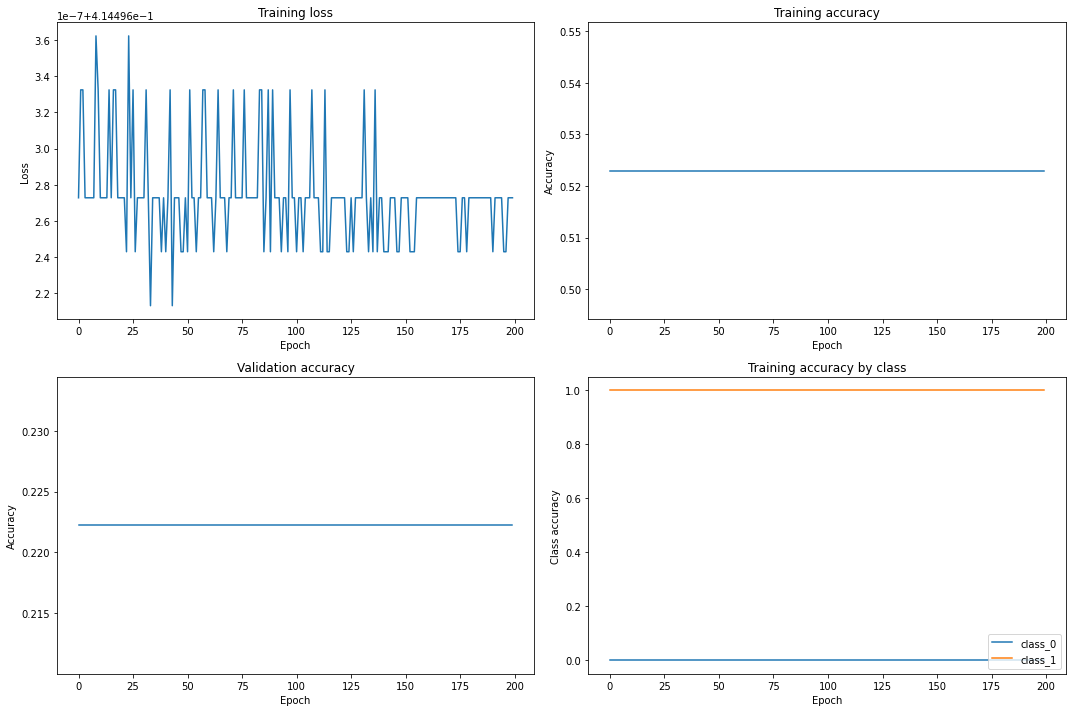

In [29]:
# Display graphs of how the model performed
from scipy.ndimage.filters import gaussian_filter1d

def smooth(key):
  return gaussian_filter1d(history.history[key], sigma=2)

print("Final loss: ", history.history['loss'][-1])
print("Final training accuracy: ", round(history.history['train_accuracy'][-1]*100), "%")

plt.rcParams['figure.figsize'] = [15, 10]

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'])
plt.title("Training loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(2, 2, 2)
plt.plot(smooth('train_accuracy'))
plt.title("Training accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.subplot(2, 2, 3)
plt.plot(smooth('val_accuracy'))
plt.title("Validation accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.subplot(2, 2, 4)
for label in CLASS_LABELS:
  plt.plot(smooth("train_class_acc_"+str(label)))
plt.title("Training accuracy by class")
plt.ylabel('Class accuracy')
plt.xlabel('Epoch')
plt.legend(['class_'+str(label) for label in CLASS_LABELS], loc='lower right')

plt.tight_layout()
plt.show()


## Test the model

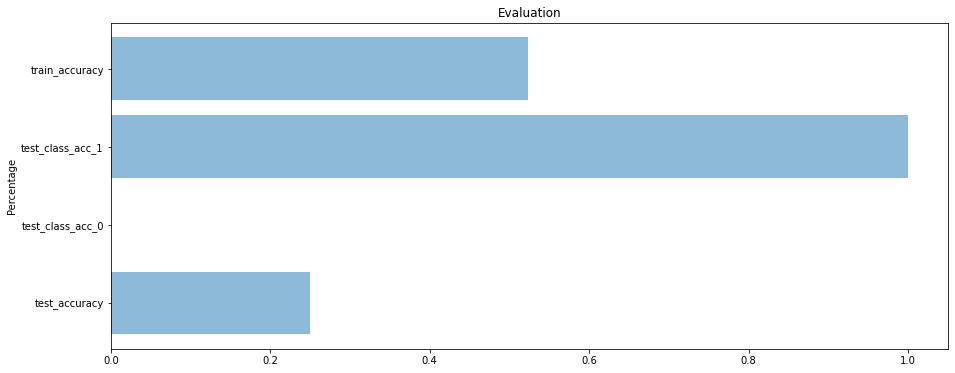

[0.25, 0.0, 1.0, 0.5229358077049255]

In [30]:
# Apply the trained model to our test data (that is, the held-out node labels)
# and measure how it performs
results = model.evaluate(
    initial_state, 
    y_test, 
    steps=1, 
    batch_size=NODE_COUNT, 
    verbose=0)

# Get test metrics
results_dict = dict(zip(model.metrics_names, results))
for name in model.metrics_names:
  if "test" not in name:
    del results_dict[name]

# Add train accuracy from the earlier training history
results_dict["train_accuracy"] = history.history['train_accuracy'][-1]

results_keys = list(results_dict.keys())
results_values = [results_dict[key] for key in results_keys]

plt.rcParams['figure.figsize'] = [15, 6]

# Display a bar chart
y_pos = np.arange(len(results_dict))
plt.barh(y_pos, results_values, align='center', alpha=0.5)
plt.yticks(y_pos, results_keys)
plt.ylabel('Percentage')
plt.title('Evaluation')
plt.show()

results_values

## Exercise questions and next steps


[Add your answers and discoveries to the answer document](https://docs.google.com/document/d/1QdAEOYnJ5AwFczNQZk5ZZo1Ng7_shn33GzQPdumnsvI/edit?usp=sharing)


- What train and test accuracy did you get?

- What modifications did you try to the network? How did they perform?

- Are there other graphs you find it useful to produce?

- What is the theoretical capabilities of this network? Do we need other methods of graph machine learning?

- Find an example of a Graph Convolutional Network being used in industry, link to it here and provide a summary

- How would you scale this network to a larger graph? What challenges might you encounter?

- Imagine you’re applying this method to Twitter’s tweet-reply graph. It’s constantly changing. How could you apply this method (which currently is written for a static graph)?

- How could you apply this to language (e.g. how could you treat language as a graph?)

